<a href="https://colab.research.google.com/github/min207/2023-1-ESAA/blob/main/ESAA230526.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **04. 모델 세부 설정**

In [1]:
# 입력 데이터 준비

import tensorflow as tf

# 케라스의 내장 데이터셋에서 mnist 데이터 로드
mnist = tf.keras.datasets.mnist

# load_data()로 데이터 로드
(x_train, y_train), (x_test, y_test)=mnist.load_data()

# 로드된 데이터셋 확인
print('train set:', x_train.shape, y_train.shape)
print('test set:', x_test.shape, y_test.shape)

# 데이터 정규화
x_train = x_train/x_train.max()
x_test = x_test/x_test.max()

11490434/11490434 [==============================] - 0s 0us/step
train set: (60000, 28, 28) (60000,)
test set: (10000, 28, 28) (10000,)


### **4-1. 초기값 설정**
- Dense 레이어는 기본 초기화 방법으로 Glorot Uniform 초기화 방법이 설정되어있음
  + kernel_initializer 매개변수 설정을 통해 다르게 설정 가능
  + 문자열로 지정하거나 클래스 인스턴스로 지정 

In [2]:
dense = tf.keras.layers.Dense(256, activation='relu')
dense.get_config()['kernel_initializer']

{'class_name': 'GlorotUniform', 'config': {'seed': None}}

In [3]:
# 문자열 초기화
dense = tf.keras.layers.Dense(256, kernel_initializer='he_normal', activation='relu')
print(dense.get_config()['kernel_initializer'])

# 클래스 인스턴스 초기화
he_normal = tf.keras.initializers.HeNormal()
dense = tf.keras.layers.Dense(256, kernel_initializer=he_normal, activation='relu')
print(dense.get_config()['kernel_initializer'])

{'class_name': 'HeNormal', 'config': {'seed': None}}
{'class_name': 'HeNormal', 'config': {'seed': None}}


> - 글로럿 초기화
- Yann Lecun 초기화
- He 초기화
- 정규분포, 연속균등 분포 초기화






-----
### **4-2. 규제**
- 모델의 과대적합을 해소하기 위해 L1, L2 규제 적용 가능
- 기본값은 규제 적용 x: kernel_regularizer = None
  + 즉, 레이어에 규제 적용을 위해서는 별도의 설정 필요 

In [4]:
# 기본값
dense = tf.keras.layers.Dense(256, activation='relu')
dense.get_config()

{'name': 'dense_3',
 'trainable': True,
 'dtype': 'float32',
 'units': 256,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

> - 모델을 구성하는 레이어마다 규제 적용 가능: kernel_regularizer에 L1, L2 규제 지정  

In [5]:
# L1 규제 적용
dense = tf.keras.layers.Dense(256, kernel_regularizer='l1', activation='relu')
print(dense.get_config()['kernel_regularizer'])

# 클래스 인스턴스 적용, alpha=0.1 변경
regularizer = tf.keras.regularizers.l1(l1=0.1)
dense = tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu')
print(dense.get_config()['kernel_regularizer'])

{'class_name': 'L1', 'config': {'l1': 0.009999999776482582}}
{'class_name': 'L1', 'config': {'l1': 0.10000000149011612}}


### **4-3. 드롭아웃**
- 드롭아웃: 딥러닝 모델의 과대적합 문제를 해결하기 위해 제안된 아이디어로, 실무적으로 효과가 좋음 
  + 모든 노드를 연결하지 않고 확률적으로 노드의 일부 신호를 임의로 삭제하여 가중치 파라미터의 개수를 줄이는 방법으로 과대적합 방지
  + 모델 훈련 시에는 드롭아웃이 적용되지만, 예측 시에는 모든 노드를 활용 

In [6]:
# dropout 25% 비율 적용 (25% 노드가 삭제)
tf.keras.layers.Dropout(0.25)

### **4-4. 배치 정규화**
- 배치 정규화: 각 층에서 활성화 함수를 통과하기 전 미니 배치의 스케일을 정규화하는 것으로, 다음 층으로 데이터를 전달하기 전에 스케일을 조정하기 때문에 보다 안정적이고 성능이 뛰어난 모델을 훈련시킬 수 있음 

- 케라스에서 클래스 함수로 지원하기 때문에 별도의 코드 구현이 필요하지 않고 클래스 인스턴스를 생성해 추가 가능 

In [9]:
# model A: Dense+ReLu
model_a = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_a.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                50240     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 10)                330       
                                                                 
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


In [8]:
# model B: Dense+BatchNorm+ReLU
model_b = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # 배치 정규화 후 활성화 함수 적용
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(32),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # 배치 정규화 후 활성화 함수 적용
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(10, activation='softmax')
])
model_b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                      

> - 결과를 살펴보면, 배치 정규화만 추가해도 손실이 이전 대비 안정적이고 빠르게 수렴하는 것을 확인 가능 


----

### **4-5. 활성화 함수**
- 클래스 인스턴스로 선언하여 하이퍼파라미터 값을 변경하여 적용 가능 

In [10]:
# LeakyReLU 기본 설정
tf.keras.layers.LeakyReLU()

# LeakyReLU, alpha=0.2로 변경
tf.keras.layers.LeakyReLU(alpha=0.2)

In [11]:
# model C: Dense+BatchNorm+LeakyReLU(0,2)
model_c = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # LeakyReLU, alpha=0.2 적용
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Dense(32),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # LeakyReLU, alpha=0.2 적용
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Dense(10, activation='softmax')
])

# 모델 요약
model_c.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                50240     
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                      

> - 세 모델의 손실 수렴 속도 확인
    + a: Dense 레이어 + ReLU 활성화 함수
    + b: Dense 레이어 + 배치 정규화
    + c: Dense 레이어 + 배치 정규화 + LeakyReLU(0.2) 활성화 함수 

In [14]:
model_a.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_b.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_c.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model A : Dense + ReLU
history_a = model_a.fit(x_train, y_train,
                      validation_data=(x_test, y_test), epochs=10)
# Model B : Dense + BatchNorm + ReLU
history_b = model_b.fit(x_train, y_train,
                      validation_data=(x_test, y_test), epochs=10)
# Model C : Dense + BatchNorm + LeakyReLU(0,2)
history_c = model_c.fit(x_train, y_train,
                      validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0295 - accuracy: 0.9902 - val_loss: 0.0979 - val_accuracy: 0.9737
Epoch 2/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0236 - accuracy: 0.9924 - val_loss: 0.0965 - val_accuracy: 0.9766
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0225 - accuracy: 0.9924 - val_loss: 0.1144 - val_accuracy: 0.9752
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0203 - accuracy: 0.9930 - val_loss: 0.1028 - val_accuracy: 0.9763
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0179 - accuracy: 0.9939 - val_loss: 0.1114 - val_accuracy: 0.9751
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0160 - accuracy: 0.9943 - val_loss: 0.1201 - val_accuracy: 0.9722
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0170 - accuracy: 0.9938 - val_loss: 0.1090 - val_accur

> - 시각화로 epoch별 검증 손실의 감소 추이 확인 

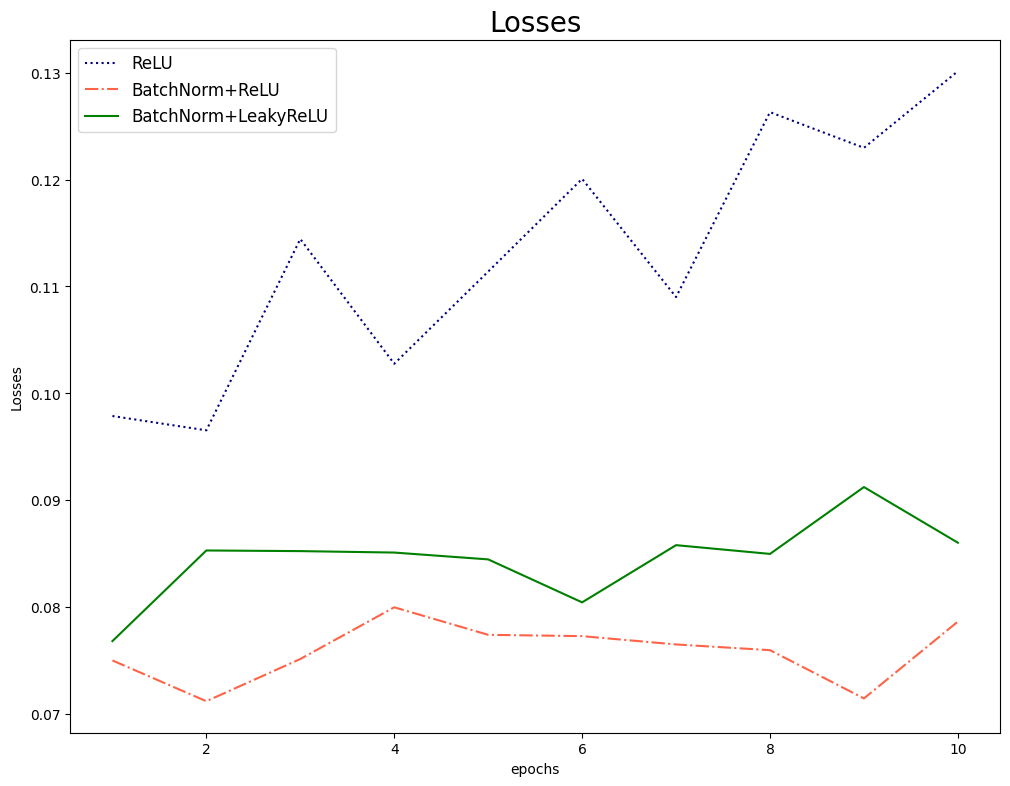

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, 11), history_a.history['val_loss'], color='navy', linestyle=':')
plt.plot(np.arange(1, 11), history_b.history['val_loss'], color='tomato', linestyle='-.')
plt.plot(np.arange(1, 11), history_c.history['val_loss'], color='green', linestyle='-')

plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.legend(['ReLU', 'BatchNorm+ReLU', 'BatchNorm+LeakyReLU'], fontsize=12)
plt.show()

## **06. 모델 저장 및 불러오기**

----
### **6-1. 모델을 파일로 저장**
- 훈련을 종료하여 가중치가 업데이트된 모델 인스턴스 저장 가능: save() 메소드 이용
  + HDF5 포맷과 SavedModel 포맷 방법
  + HDF5: 대용량 데이터 저장

In [17]:
# 모델을 h5 포맷으로 저장
model_b.save('h5-model.h5')

### **6-2. 저장된 모델 복원**
- tensorflow.kerase.models.load_model() 메소드로 저장된 모델 복원 가능

In [18]:
# 모델 복원
h5_model = tf.keras.models.load_model('h5-model.h5')
h5_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                      

- 검증을 통해 모델이 잘 복원되었는지 확인 

In [19]:
# 모델 검증
loss, acc = h5_model.evaluate(x_test, y_test, verbose=0)
print(f'h5_model] loss: {loss:.5f}, acc: {acc:.5f}')

h5_model] loss: 0.07866, acc: 0.97930


- 확장자를 생략하면 텐서플로2에서 기본으로 지원하는 파일 포맷인 SavedModel 포맷으로 저장

In [20]:
# 모델을 SavedModel 포맷으로 저장
model_b.save('saved-model')

In [21]:
# 모델 복원
saved_model = tf.keras.models.load_model('saved-model')
saved_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                      

- 두 형식 모두 동일한 성능을 보임 

In [22]:
# 모델 검증(HDF5 포맷)
loss, acc = h5_model.evaluate(x_test, y_test, verbose=0)
print(f'h5_model] loss: {loss:.5f}, acc: {acc:.5f}')

# 모델 검증(SavedModel 포맷)
loss, acc = saved_model.evaluate(x_test, y_test, verbose= 0)
print(f'saved_model] loss: {loss:.5f}, acc: {acc:.5f}')

h5_model] loss: 0.07866, acc: 0.97930
saved_model] loss: 0.07866, acc: 0.97930


## **07. 복잡한 모델 생성**
### **7-1. 함수형 API**
- 다양하고 복잡한 모델 구조 구현 가능
  + 다중입력, 다중출력, 여러 개의 층을 같은 레벨에 배치하는 구조

- 먼저 input 레이어 정의
  + 데이터의 입력 형태 정의 

In [23]:
import tensorflow as tf

# 모델의 레이어를 체인 구조로 연결 input 레이어 정의
input_layer = tf.keras.Input(shape=(28, 28), name='InputLayer')

# 모델의 레이어를 체인 구조로 연결
x1 = tf.keras.layers.Flatten(name='Flatten')(input_layer)
x2 = tf.keras.layers.Dense(256, activation='relu', name='Dense1')(x1)
x3 = tf.keras.layers.Dense(64, activation='relu', name='Dense2')(x2)
x4 = tf.keras.layers.Dense(10, activation='softmax', name='OutputLayer')(x3)

- 레이어마다 name 매개변수로 이름 부여 가능
  + summary()로 요약 출력 시 이름이 함께 출력
- 체인 방식으로 연결 후 tf.keras.Model()에 입력 레이어와 출력 레이어 정의해 모델 생성 

In [24]:
# 모델 생성
func_model = tf.keras.Model(inputs=input_layer, outputs=x4, name='FunctionalModel')

# 모델 요약
func_model.summary()

Model: "FunctionalModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28)]          0         
                                                                 
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 Dense1 (Dense)              (None, 256)               200960    
                                                                 
 Dense2 (Dense)              (None, 64)                16448     
                                                                 
 OutputLayer (Dense)         (None, 10)                650       
                                                                 
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


- 케라스의 유틸 패기지에서 제공하는 plot_model 모듈을 활용해 모델의 구조도 시각화 

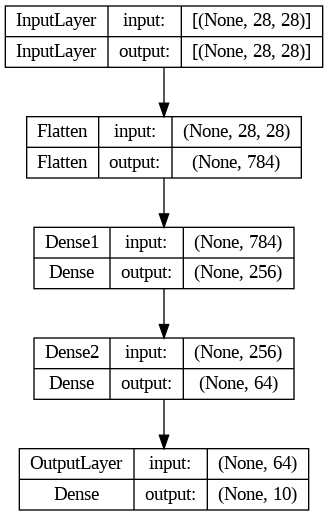

In [25]:
from tensorflow.keras.utils import plot_model

# 구조도 시각화
plot_model(func_model, show_shapes=True, show_layer_names=True, to_file='model.png')

- 생성된 모델 인스턴스에 compile() 메소드로 모델을 컴파일하고 fit() 메소드로 훈련, evaluate() 메소드로 검증 수행 

In [26]:
# 컴파일
func_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련
func_model.fit(x_train, y_train, epochs=3)

# 검증
loss, acc = func_model.evaluate(x_test, y_test, verbose=0)
print(f'Functional Model] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2122 - accuracy: 0.9379
Epoch 2/3
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0892 - accuracy: 0.9724
Epoch 3/3
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0608 - accuracy: 0.9809
Functional Model] loss: 0.07659, acc: 0.97800


### **7-2. 모델 서브클래싱**
- 클래스를 직접 상속받아 사용자가 직접 서브클래스로 딥러닝 모델 구현 가능
- 함수형 API로 생성한 모델과의 성능 차이는 없음 


- tf.keras.Model를 상속받아 생성하고자 하는 모델 클래스 구현
- 모델의 `__init__()`함수에 레이어를 정의하고 레이어의 하이퍼파라미터 정의

In [27]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    # 초기값 설정
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(256, activation='relu')
    self.dense2 = tf.keras.layers.Dense(64, activation='relu')
    self.dense3 = tf.keras.layers.Dense(10, activation='softmax')

  # method overiding
  # 훈련용 함수 정의
  # x는 input
  def call(self, x):
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    return x

- call() 함수를 메소드 오버라이딩으로 구현
  + call() 메소드: fit() 메소드가 호출되어 훈련하는 경우 호출될 함수
  + 모델의 입력부터 출력까지의 흐름, 순전파를 정의하고 모든 레이어를 체인처럼 연결 후 최종 출력 값을 return 

In [28]:
# 모델 생성
mymodel = MyModel()

# 모델의 이름 설정
mymodel._name = 'subclass_model'

# 모델 input 정의
mymodel(tf.keras.layers.Input(shape=(28, 28)))

# 모델 요약
mymodel.summary()

Model: "subclass_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dense_18 (Dense)            multiple                  200960    
                                                                 
 dense_19 (Dense)            multiple                  16448     
                                                                 
 dense_20 (Dense)            multiple                  650       
                                                                 
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


- MyModel을 생성자로 인스턴스 생성
- 생성자로 객체를 생성해 저장한 mymodel 변수에 바로 summary()로 요약 출력하는 것은 불가능
  + input_shape이 정의되지 않아 전체 모델의 구조를 생성하지 못하기 때문 

In [29]:
# 컴파일
mymodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련
mymodel.fit(x_train, y_train, epochs=3)

# 검증
loss, acc = mymodel.evaluate(x_test, y_test, verbose=0)
print(f'Subclassing Model] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2152 - accuracy: 0.9355
Epoch 2/3
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0895 - accuracy: 0.9723
Epoch 3/3
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0597 - accuracy: 0.9816
Subclassing Model] loss: 0.09081, acc: 0.97250


### **7-3. 서브클래싱 모델 파라미터를 활용한 생성**
- Model Subclassing은 장점으로 생성자 파라미터로 모델 내부 레이어의 하이퍼파라미터를 지정할 수 있음
  + 모델의 생성자 파라미터를 추가하여 동적으로 레이어의 유닛 개수를 초기화하는 예제 

In [30]:
class MyModel(tf.keras.Model):

  # 생성자 파라미터 추가
  def __init__(self, units, num_classes):
    super(MyModel, self).__init__()
    # 초기값 설정
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(units, activation='relu')
    self.dense2 = tf.keras.layers.Dense(units/4, activation='relu')
    self.dense3 = tf.keras.layers.Dense(num_classes, activation='softmax')

  # class overiding
  # 훈련용 함수 정의
  # x는 input
  def call(self, x):
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    return x

- 모델의 생성자 파라미터로 기준이 되는 unit의 개수를 입력받아 Dense 레이어의 유닛 개수를 계산하여 결정 

In [31]:
# 모델 생성
mymodel = MyModel(256, 10)

# 모델 input 정의
mymodel(tf.keras.layers.Input(shape=(28, 28)))

# 모델 요약
mymodel.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 dense_21 (Dense)            multiple                  200960    
                                                                 
 dense_22 (Dense)            multiple                  16448     
                                                                 
 dense_23 (Dense)            multiple                  650       
                                                                 
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


- 동적으로 설정한 레이어의 파라미터가 초기화된 것을 확인 

In [32]:
# 컴파일
mymodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련
mymodel.fit(x_train, y_train, epochs=3)

# 검증
loss, acc = mymodel.evaluate(x_test, y_test, verbose=0)
print(f'Subclassing Model w.parameters] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2178 - accuracy: 0.9348
Epoch 2/3
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0881 - accuracy: 0.9726
Epoch 3/3
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0606 - accuracy: 0.9816
Subclassing Model w.parameters] loss: 0.08282, acc: 0.97350
